# Weak/Integral SINDy Feature Overview
It is often difficult to identify dynamical systems in the presence of substantial noise. Towards that end, a number of publications have used SINDy to identify the weak-formulation (integral formulation) of the system of ODEs or PDEs. This allows one to avoid taking high-order derivatives of noisy data (high-order derivatives of noisy data will amplify the noise). 

This notebook provides a simple overview of the weak form PDE functionality of PySINDy, following the examples in the PDE-FIND paper (Rudy, Samuel H., Steven L. Brunton, Joshua L. Proctor, and J. Nathan Kutz. "Data-driven discovery of partial differential equations." Science Advances 3, no. 4 (2017): e1602614) and Reinbold, P. A., Gurevich, D. R., & Grigoriev, R. O. (2020). Using noisy or incomplete data to discover models of spatiotemporal dynamics. Physical Review E, 101(1), 010203. Jupyter notebook written by Alan Kaptanoglu.

An interactive version of this notebook is available on binder
[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/dynamicslab/pysindy/v1.5.1?filepath=examples/12_weakform_SINDy_examples.ipynb)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp
from sklearn.linear_model import Lasso
from scipy.io import loadmat
from sklearn.metrics import mean_squared_error
from pysindy.utils.odes import lorenz

import pysindy as ps

# Ignore matplotlib deprecation warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Seed the random number generators for reproducibility
np.random.seed(100)

# integration keywords for solve_ivp, typically needed for chaotic systems
integrator_keywords = {}
integrator_keywords['rtol'] = 1e-12
integrator_keywords['method'] = 'LSODA'
integrator_keywords['atol'] = 1e-12

In [2]:
# Import some interpolation and integration functions
from scipy.interpolate import RectBivariateSpline
from scipy.integrate import trapezoid
from pysindy.differentiation import FiniteDifference
from scipy.interpolate import RegularGridInterpolator
from scipy.interpolate import interp1d


# Convert u_dot into a weak form using the pre-defined ode_lib
def convert_u_dot_0D(u, t, ode_lib):  # For weak form ODES
    K = ode_lib.K
    num_pts_per_domain = ode_lib.num_pts_per_domain
    u_dot_integral = np.zeros((K, u.shape[-1]))
    for j in range(u.shape[-1]):
        u_interp = interp1d(t, u[:, j], kind='cubic')
        for k in range(K):
            # Interpolate u onto the kth subdomain
            u_new = u_interp(ode_lib.tgrid_k[k, :])
            # Get the smooth weights on the kth subdomain
            w_diff = ode_lib._smooth_ppoly(
                        [],
                        ode_lib.tgrid_k[k, :], k, 0, 0, 0, 1
                    )
            # Integrate over t points in the kth subdomain
            u_dot_integral[k, j] = (-1) * (
                trapezoid(
                    u_new * w_diff, 
                    x=ode_lib.tgrid_k[k, :], 
                    axis=0
                )
            )
    return u_dot_integral


# Convert u_dot into a weak form using the pre-defined pde_lib
def convert_u_dot_1D(u, t, pde_lib):  # For weak form 1D PDES
    K = pde_lib.K
    num_pts_per_domain = pde_lib.num_pts_per_domain
    x = pde_lib.spatial_grid
    u_dot_integral = np.zeros((K, u.shape[-1]))
    # Define interpolation object to interpolate u(x, time) onto the grid
    # spanned by X, t
    for j in range(u.shape[-1]):
        u_interp = RectBivariateSpline(x, t, u[:, :, j])
        for k in range(K):
            X = np.ravel(pde_lib.X[k, :, :])
            tgrid = np.ravel(pde_lib.t[k, :, :])
            # Interpolate u onto the kth subdomain
            u_new = u_interp.ev(X, tgrid)
            u_new = np.reshape(u_new, (num_pts_per_domain,
                                       num_pts_per_domain,
                                       1))
            # Get the smooth weights on the kth subdomain
            w_diff = pde_lib._smooth_ppoly(
                        np.reshape(pde_lib.xgrid_k[k, :], (num_pts_per_domain, 1)),
                        pde_lib.tgrid_k[k, :], k, 0, 0, 0, 1
                    )
            # Integrate over x, t points in the kth subdomain
            u_dot_integral[k, j] = (-1) * (
                trapezoid(
                    trapezoid(
                        u_new * w_diff, 
                        x=pde_lib.xgrid_k[k, :], 
                        axis=0
                    ),
                    x=pde_lib.tgrid_k[k, :], 
                    axis=0
                )
            )
    return u_dot_integral


# Convert u_dot into a weak form using the pre-defined pde_lib
def convert_u_dot_2D(u, t, pde_lib):  # For weak form 2D PDES
    K = pde_lib.K  
    num_pts_per_domain = pde_lib.num_pts_per_domain
    x = pde_lib.spatial_grid
    u_dot_integral = np.zeros((K, 2))
    for j in range(u.shape[-1]):
        # Define interpolation object to interpolate u(x, y, t) onto the grid
        # spanned by X, Y, t
        u_interp = RegularGridInterpolator((pde_lib.spatial_grid[:, 0, 0], 
                                            pde_lib.spatial_grid[0, :, 1],
                                            t), 
                                           u[:, :, :, j])
        for k in range(K):
            X = np.ravel(pde_lib.X[k, :, :, :])
            Y = np.ravel(pde_lib.Y[k, :, :, :])
            tgrid = np.ravel(pde_lib.t[k, :, :, :])
            XYt = np.array((X, Y, tgrid)).T
            # Interpolate u onto the kth subdomain
            u_new = u_interp(XYt)
            u_new = np.reshape(u_new, (num_pts_per_domain,
                                       num_pts_per_domain,
                                       num_pts_per_domain,
                                       1))
            # Get the smooth weights on the kth subdomain
            w_diff = pde_lib._smooth_ppoly(
                        np.transpose((pde_lib.xgrid_k[k, :], pde_lib.ygrid_k[k, :])),
                        pde_lib.tgrid_k[k, :], k, 0, 0, 0, 1
                    )
            # Integrate over x, y, t points in the kth subdomain
            u_dot_integral[k, j] = (-1) * (
                trapezoid(
                    trapezoid(
                        trapezoid(
                            u_new * w_diff, 
                            x=pde_lib.xgrid_k[k, :], 
                            axis=0
                        ),
                        x=pde_lib.ygrid_k[k, :],
                        axis=0
                    ),
                    x=pde_lib.tgrid_k[k, :], 
                    axis=0
                )
            )
    return u_dot_integral


# Convert u_dot into a weak form using the pre-defined pde_lib
def convert_u_dot_3D(u, t, pde_lib):  # For weak form 3D PDES
    K = pde_lib.K  
    num_pts_per_domain = pde_lib.num_pts_per_domain
    u_dot_integral = np.zeros((K, 2))
    for j in range(u.shape[-1]):
        # Define interpolation object to interpolate u(x, y, t) onto the grid
        # spanned by X, Y, t
        u_interp = RegularGridInterpolator((pde_lib.spatial_grid[:, 0, 0, 0],
                                            pde_lib.spatial_grid[0, :, 0, 1],
                                            pde_lib.spatial_grid[0, 0, :, 2],
                                            t), 
                                           u[:, :, :, :, j])
        for k in range(K):
            X = np.ravel(pde_lib.X[k, :, :, :, :])
            Y = np.ravel(pde_lib.Y[k, :, :, :, :])
            Z = np.ravel(pde_lib.Z[k, :, :, :, :])
            tgrid = np.ravel(pde_lib.t[k, :, :, :, :])
            XYZt = np.array((X, Y, Z, tgrid)).T
            # Interpolate u onto the kth subdomain
            u_new = u_interp(XYZt)
            u_new = np.reshape(u_new, (num_pts_per_domain,
                                       num_pts_per_domain,
                                       num_pts_per_domain,
                                       num_pts_per_domain,
                                       1))
            # Get the smooth weights on the kth subdomain
            w_diff = pde_lib._smooth_ppoly(
                        np.transpose((pde_lib.xgrid_k[k, :], 
                                      pde_lib.ygrid_k[k, :],
                                      pde_lib.zgrid_k[k, :])),
                        pde_lib.tgrid_k[k, :], k, 0, 0, 0, 1
                    )
            # Integrate over x, y, t points in the kth subdomain
            u_dot_integral[k, j] = (-1) * (
                trapezoid(
                    trapezoid(
                        trapezoid(
                            trapezoid(
                                u_new * w_diff, 
                                x=pde_lib.xgrid_k[k, :], 
                                axis=0
                            ),
                            x=pde_lib.ygrid_k[k, :],
                            axis=0
                        ),
                        x=pde_lib.zgrid_k[k, :],
                        axis=0
                    ),
                    x=pde_lib.tgrid_k[k, :], 
                    axis=0
                )
            )
    return u_dot_integral

# Test weak form ODE functionality on Lorenz equation

In [3]:
# Generate measurement data
dt = 0.002
t_train = np.arange(0, 10, dt)
t_train_span = (t_train[0], t_train[-1])
u0_train = [-8, 8, 27]
u_train = solve_ivp(lorenz, t_train_span, u0_train, t_eval=t_train, **integrator_keywords).y.T

# Instantiate and fit the SINDy model with u_dot
u_dot = ps.FiniteDifference()._differentiate(u_train, t=dt)
model = ps.SINDy()
model.fit(u_train, x_dot=u_dot, t=dt)
model.print()

# Define weak form ODE library via weak_form=True,
# defaults to derivative_order = 0 if not specified,
# and if spatial_grid is not specified, defaults to None,
# which allows weak form ODEs.
library_functions = [lambda x: x, lambda x: x * x, lambda x, y: x * y]
library_function_names = [lambda x: x, lambda x: x + x, lambda x, y: x + y]
ode_lib = ps.PDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    temporal_grid=t_train,
    include_bias=True,
    is_uniform=True,
    weak_form=True,
    num_pts_per_domain=100,
    K=100,
)

u_dot_train_integral = convert_u_dot_0D(u_train, t_train, ode_lib)

# Instantiate and fit the SINDy model with the integral of u_dot
optimizer = ps.SR3(
    threshold=0.05, thresholder="l1", max_iter=1000, normalize_columns=True, tol=1e-10
)
model = ps.SINDy(feature_library=ode_lib, optimizer=optimizer)
model.fit(u_train, x_dot=u_dot_train_integral)
model.print()


(x0)' = -9.999 x0 + 9.999 x1
(x1)' = 27.992 x0 + -0.999 x1 + -1.000 x0 x2
(x2)' = -2.666 x2 + 1.000 x0 x1
(x0)' = -10.000 x0 + 10.000 x1
(x1)' = 28.001 x0 + -1.000 x1 + -1.000 x0x2
(x2)' = 0.001 1 + -2.667 x2 + 1.000 x0x1


/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/sr3.py:324: ConvergenceWarning: SR3._reduce did not converge after 1000 iterations.
  ConvergenceWarning,


Performance should improve as the number of sub-domain integrations points increases (numerically approximating the integrals better and better) and number of sub-domains increases (more points for regression). Let's use some noisy Lorenz data and investigate.

In [4]:
# Generate measurement data
dt = 0.002
t_train = np.arange(0, 10, dt)
t_train_span = (t_train[0], t_train[-1])
u0_train = [-8, 8, 27]
u0_test = [8, 7, 15]
u_train = solve_ivp(lorenz, t_train_span, u0_train, 
                    t_eval=t_train, **integrator_keywords).y.T
u_test = solve_ivp(lorenz, t_train_span, u0_test, 
                   t_eval=t_train, **integrator_keywords).y.T
rmse = mean_squared_error(u_train, np.zeros((u_train).shape), squared=False)
u_dot_clean = ps.FiniteDifference()._differentiate(u_test, t=dt)
u_clean = u_test
u_train = u_train + np.random.normal(0, rmse / 5.0, u_train.shape)  # Add 20% noise
rmse = mean_squared_error(u_test, np.zeros(u_test.shape), squared=False)
u_test = u_test + np.random.normal(0, rmse / 5.0, u_test.shape)  # Add 20% noise
u_dot = ps.FiniteDifference()._differentiate(u_test, t=dt)

# Same library terms as before
library_functions = [lambda x: x, lambda x: x * x, lambda x, y: x * y]
library_function_names = [lambda x: x, lambda x: x + x, lambda x, y: x + y]

# Scan over the number of integration points and the number of subdomains
n = 10
errs = np.zeros((n, n))
pts_scan = np.linspace(4, 40, n, dtype=int)
K_scan = np.linspace(20, 300, n, dtype=int)
for i, K in enumerate(K_scan):
    for j, pts in enumerate(pts_scan):
        ode_lib = ps.PDELibrary(
            library_functions=library_functions,
            function_names=library_function_names,
            temporal_grid=t_train,
            include_bias=True,
            is_uniform=True,
            weak_form=True,
            num_pts_per_domain=pts,
            K=K,
        )
        opt = ps.SR3(
            threshold=0.05,
            thresholder="l0",
            max_iter=1000,
            normalize_columns=True,
            tol=1e-10,
        )
        u_dot_train_integral = convert_u_dot_0D(u_train, t_train, ode_lib)

        # Instantiate and fit the SINDy model with the integral of u_dot
        model = ps.SINDy(feature_library=ode_lib, optimizer=opt)
        model.fit(u_train, x_dot=u_dot_train_integral, quiet=True)
        errs[i, j] = np.sqrt(
            (
                np.sum((u_dot_train_integral - opt.Theta_ @ opt.coef_.T) ** 2)
                / np.sum(u_dot_train_integral ** 2)
            )
            / u_dot_train_integral.shape[0]
        )


Performance clearly improves as the number of subdomains and number of integrations points increase! We can also see that Lorenz is correctly identified despite ~20% noise levels.


The plot belows shows that we can use the weak-formulation to build models that are robust to noise, and additionally indicates convergence as the regression becomes larger and more accurate. 

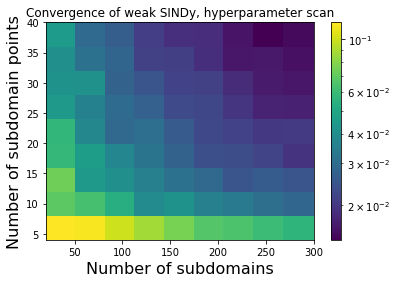

In [5]:
from matplotlib.colors import LogNorm
plt.pcolor(K_scan, pts_scan, errs.T, norm=LogNorm())
plt.xlabel('Number of subdomains', fontsize=16)
plt.ylabel('Number of subdomain points', fontsize=16)
plt.title('Convergence of weak SINDy, hyperparameter scan', fontsize=12)
plt.colorbar()
plt.show()

The default scikit-learn functionality for `model.predict` is to return x_dot of the same type as the training data. So for weak form, model.predict returns a prediction of the weak form of x_dot, rather than a prediction of x_dot.

We can get around this with a bit of a cheat... inputting the model coefficients from the weak form into the original (not weak) model, and use this to predict!
Beware, this requires: 
1. That the libraries and library ordering are identical in the two models!
2. For PDEs, the spatial grids must be identical. This means you need to reuse the library. If you initialize a new PDE library, a new set of subdomains is randomly chosen.
3. Note that the candidate libraries $\Theta$ are fundamentally different in the weak and non-weak models. In the former, all the columns are integrated in time (and for PDEs, also in space)! This means if you forecast the weak model coefficients with the non-weak model, you are using a $\Theta$ matrix that is very noisy! In other words, using the weak form fixed the issues with noise, but forecasting with the original model still has the noise in $\Theta$.
4. For all these reasons, we will use the error in the coefficients, rather than the error in the predictions, after this example.

Weak form model: 
(x0)' = -3.196 1 + -5.071 x0 + 8.719 x1 + 0.328 x2 + 0.079 x0x0 + 0.006 x1x1 + -0.010 x2x2 + -0.066 x0x1 + -0.127 x0x2 + -0.003 x1x2
(x1)' = -0.958 1 + 22.746 x0 + -0.086 x1 + 0.009 x2 + -0.130 x0x0 + 0.048 x1x1 + 0.008 x2x2 + 0.020 x0x1 + -0.867 x0x2 + 0.027 x1x2
(x2)' = -11.505 1 + -0.711 x0 + -0.683 x1 + -1.727 x2 + -0.079 x0x0 + 0.116 x1x1 + -0.012 x2x2 + 0.876 x0x1 + 0.015 x0x2 + 0.038 x1x2
Regular model: 
(x0)' = -1.091 1 + 4.811 x0 + 1.196 x1 + 0.861 x2 + 0.027 x0x0 + -0.171 x1x1 + -0.034 x2x2 + 0.208 x0x1 + -0.336 x0x2 + 0.160 x1x2
(x1)' = 9.177 1 + 7.419 x0 + 8.758 x1 + -0.389 x2 + -0.173 x0x0 + -0.283 x1x1 + 0.015 x2x2 + 0.519 x0x1 + -0.403 x0x2 + -0.272 x1x2
(x2)' = -20.751 1 + -1.726 x0 + 1.450 x1 + -1.025 x2 + 0.437 x0x0 + 0.416 x1x1 + -0.029 x2x2 + -0.056 x0x1 + 0.075 x0x2 + -0.073 x1x2


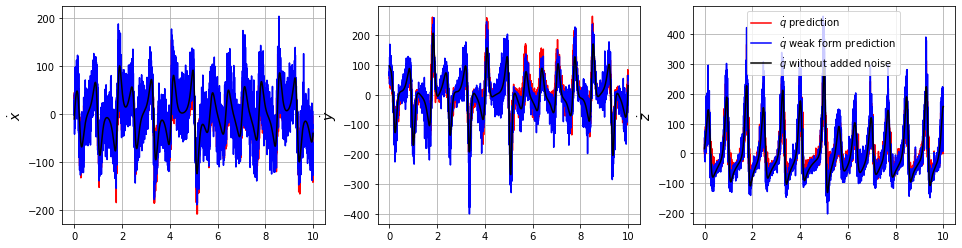

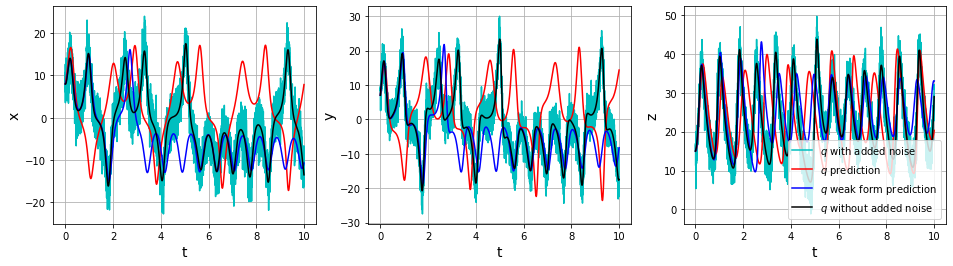

In [6]:
# Fit a weak form model
ode_lib = ps.PDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    temporal_grid=t_train,
    include_bias=True,
    is_uniform=True,
    weak_form=True,
    num_pts_per_domain=100,
    K=5000,
)
opt = ps.SR3(
    threshold=0.5, thresholder="l0", max_iter=10000, normalize_columns=True, tol=1e-10
)
u_dot_train_integral = convert_u_dot_0D(u_train, t_train, ode_lib)
model = ps.SINDy(feature_library=ode_lib, optimizer=opt)
model.fit(u_train, x_dot=u_dot_train_integral, quiet=True)
print("Weak form model: ")
model.print()

# Instantiate and fit a non-weak SINDy model
ode_lib.weak_form = False
optimizer = ps.SR3(
    threshold=0.5, thresholder="l0", max_iter=10000, normalize_columns=True, tol=1e-10
)
original_model = ps.SINDy(feature_library=ode_lib, optimizer=optimizer)
original_model.fit(u_train, t=dt, quiet=True)
print("Regular model: ")
original_model.print()
err_not_weak = np.sqrt(
    (np.sum((u_dot - optimizer.Theta_ @ optimizer.coef_.T) ** 2) / np.sum(u_dot ** 2))
    / u_dot.shape[0]
)

u_pred = original_model.simulate(u0_test, t=t_train)
u_dot_pred = original_model.predict(u_test)

feature_names = ['x', 'y', 'z']
optimizer.coef_ = opt.coef_
u_dot_weak = original_model.predict(u_test)
plt.figure(figsize=(16, 4))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.plot(t_train, u_dot_pred[:, i], "r", label=r"$\dot{q}$ prediction")
    plt.plot(t_train, u_dot_weak[:, i], "b", label=r"$\dot{q}$ weak form prediction")
    plt.plot(t_train, u_dot_clean[:, i], "k", label=r"$\dot{q}$ without added noise")
    plt.grid(True)
    plt.ylabel(r'$\dot{' + feature_names[i] + '}$', fontsize=14)
    if i == 2:
        plt.legend()

u_weak = original_model.simulate(u0_test, t=t_train)
plt.figure(figsize=(16, 4))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.plot(t_train, u_test[:, i], "c", label=r"$q$ with added noise")
    plt.plot(t_train, u_pred[:, i], "r", label=r"$q$ prediction")
    plt.plot(t_train, u_weak[:, i], "b", label=r"$q$ weak form prediction")
    plt.plot(t_train, u_clean[:, i], "k", label=r"$q$ without added noise")
    plt.grid(True)
    plt.ylabel(feature_names[i], fontsize=14)
    plt.xlabel('t', fontsize=14)
    if i == 2:
        plt.legend()


# Test weak form PDE functionality on Burgers' equation with 20% noise
Note that the weak formulation can be applied to PDEs too. 
Burgers' equation is
$u_t = -uu_x + 0.1 u_{xx}$. We will repeat all the same steps. Although weak-formulation helps with noisy data, we also show that using smoothed finite-differences (or other more advanced differentiation schemes) can also improve robustness to noise.

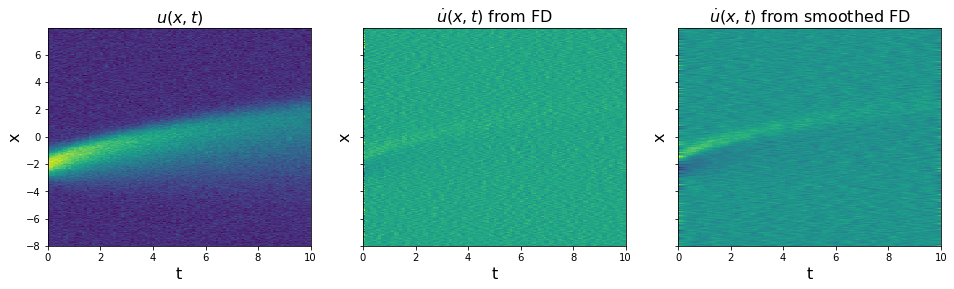

In [23]:
# Load data from .mat file
data = loadmat('data/burgers.mat')
time = np.ravel(data['t'])
x = np.ravel(data['x'])
u = np.real(data['usol'])
dt = time[1] - time[0]
dx = x[1] - x[0]
rmse = mean_squared_error(u, np.zeros(u.shape), squared=False)
u = u + np.random.normal(0, rmse / 5.0, u.shape)  # add 20% noise

# Plot u and u_dot
plt.figure(figsize=(16, 4))
plt.subplot(1, 3, 1)
plt.pcolormesh(time, x, u)
plt.xlabel('t', fontsize=16)
plt.ylabel('x', fontsize=16)
plt.title(r'$u(x, t)$', fontsize=16)
u_shaped = np.reshape(u, (len(x), len(time), 1))
u_dot = np.zeros(u_shaped.shape)
for i in range(len(x)):
    u_dot[i, :, :] = ps.FiniteDifference()._differentiate(u_shaped[i, :, :], t=dt)
plt.subplot(1, 3, 2)
plt.pcolormesh(time, x, u_dot[:, :, 0])
plt.xlabel('t', fontsize=16)
plt.ylabel('x', fontsize=16)
ax = plt.gca()
ax.set_yticklabels([])
plt.title(r'$\dot{u}(x, t)$ from FD', fontsize=16)
for i in range(len(x)):
    u_dot[i, :, :] = ps.SmoothedFiniteDifference()._differentiate(u_shaped[i, :, :], t=dt)
plt.subplot(1, 3, 3)
plt.pcolormesh(time, x, u_dot[:, :, 0])
plt.xlabel('t', fontsize=16)
plt.ylabel('x', fontsize=16)
ax = plt.gca()
ax.set_yticklabels([])
plt.title(r'$\dot{u}(x, t)$ from smoothed FD', fontsize=16)
plt.show()
# See how much SmoothedFiniteDifference improves the derivatives!

Now we reformat all the training and testing data and define the PDELibrary.

We also define two different PDELibraries and show that despite identical parameters, they have different subdomain centers, since the centers are randomly chosen within the domain when the PDELibrary is initialized.

In [24]:
# Split into training and testing data
train = range(0, int(len(time) * 0.6), 1)
test = [i for i in np.arange(len(time)) if i not in train]
u_train = u[:, train]
u_test = u[:, test]
u_dot_train = u_dot[:, train]
u_dot_test = u_dot[:, test]
t_train = time[train]
t_test = time[test]

# Flatten into 2D shape for SINDy model optimization
u_flattened = np.reshape(u, (len(x) * len(time), 1))
u_dot_flattened = np.reshape(u_dot, (len(x) * len(time), 1))
u_dot_train_flattened = np.reshape(u_dot_train, (len(x) * len(t_train), 1))
u_train_flattened = np.reshape(u_train, (len(x) * len(t_train), 1))
u_dot_test_flattened = np.reshape(u_dot_test, (len(x) * len(t_test), 1))
u_test_flattened = np.reshape(u_test, (len(x) * len(t_test), 1))

# Define weak form PDE library via weak_form=True
library_functions = [lambda x: x, lambda x: x * x]
library_function_names = [lambda x: x, lambda x: x + x]

# Show that the default behavior is that identical PDELibrary calls
# will generate different randomly-sampled subdomain grids, 
pde_lib = ps.PDELibrary(library_functions=library_functions, 
                        function_names=library_function_names, 
                        derivative_order=2, spatial_grid=x,
                        temporal_grid=t_train, include_bias=False,
                        is_uniform=True, weak_form=True, K=1000,
                        num_pts_per_domain=100)
domain_centers1 = pde_lib.domain_centers
pde_lib = ps.PDELibrary(library_functions=library_functions, 
                        function_names=library_function_names, 
                        derivative_order=2, spatial_grid=x,
                        temporal_grid=t_train, include_bias=False,
                        is_uniform=True, weak_form=True, K=1000,
                        num_pts_per_domain=100)
domain_centers2 = pde_lib.domain_centers
print(np.all(domain_centers1 == domain_centers2))

# reshape the data
u = np.reshape(u, (len(x), len(time), 1))
u_train = np.reshape(u_train, (len(x), len(t_train), 1))
u_test = np.reshape(u_test, (len(x), len(t_test), 1))

# Compute the integral u_dot terms
u_dot_integral = convert_u_dot_1D(u, time, pde_lib)
u_dot_train_integral = convert_u_dot_1D(u_train, t_train, pde_lib)
u_dot_test_integral = convert_u_dot_1D(u_test, t_test, pde_lib)

False


In [25]:
# Fit a weak form model
optimizer = ps.SR3(threshold=0.02, thresholder='l1', 
                   tol=1e-8, normalize_columns=True, max_iter=1000)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u_train_flattened, x_dot=u_dot_train_integral, quiet=True)
model.print()

(x0)' = -0.003 x0_1 + 0.089 x0_11 + -0.981 x0x0_1


In [26]:
# Show that a non-weak form model screws this up badly
pde_lib = ps.PDELibrary(library_functions=library_functions, 
                        function_names=library_function_names, 
                        derivative_order=2, spatial_grid=x,
                        include_bias=False,
                        is_uniform=True, weak_form=False)

# Fit and predict with the non-weak model
opt = ps.SR3(threshold=0.05, thresholder='l0', 
                   tol=1e-10, normalize_columns=True, max_iter=1000)
model_for_prediction = ps.SINDy(feature_library=pde_lib, optimizer=opt)
model_for_prediction.fit(u_train_flattened, x_dot=u_dot_train_flattened)

# Prints a very wrong model
model_for_prediction.print()

(x0)' = 0.162 x0 + -0.405 x0x0 + -0.002 x0_1 + -0.332 x0x0_1 + 0.019 x0x0x0_1 + -0.001 x0x0_11 + 0.001 x0x0x0_11


The takeaway here is that the weak formulation drastically improved our system identification on the Burgers' equation with added noise. The weak formulation can handle even more than 20% noise here, although then a fairly large value for K is required to obtain a decent system identification. This is required for some of the examples below, and the downside is that this slows down the code considerably. 

# Test weak-formulation PDE functionality on the Kuramoto-Sivashinsky equation
The Kuramoto-Sivashinsky equation is
$u_t = -uu_x - u_{xx} - u_{xxxx}$. We will skip noisy data for now, since we have already illustrated the pitfalls and performance with the weak form. We will revisit noisy data for the 2D reaction-diffusion example.

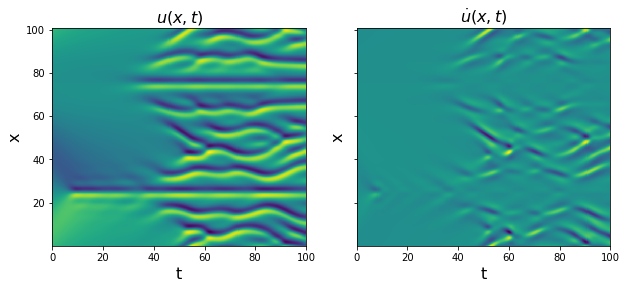

In [11]:
# Load and plot the data
data = loadmat('data/kuramoto_sivishinky.mat')
time = np.ravel(data['tt'])
x = np.ravel(data['x'])
u = data['uu']
u_flattened = np.reshape(u, (len(x) * len(time), 1))
dt = time[1] - time[0]
dx = x[1] - x[0]

# Plot u and u_dot
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.pcolormesh(time, x, u)
plt.xlabel('t', fontsize=16)
plt.ylabel('x', fontsize=16)
plt.title(r'$u(x, t)$', fontsize=16)
u_shaped = np.reshape(u, (len(x), len(time), 1))
u_dot = np.zeros((len(x), len(time), 1))
for i in range(len(x)):
    u_dot[i, :, :] = ps.FiniteDifference()._differentiate(u_shaped[i, :, :], t=dt)
plt.subplot(1, 2, 2)
plt.pcolormesh(time, x, u_dot[:, :, 0])
plt.xlabel('t', fontsize=16)
plt.ylabel('x', fontsize=16)
ax = plt.gca()
ax.set_yticklabels([])
plt.title(r'$\dot{u}(x, t)$', fontsize=16)
plt.show()

# Convert u_dot to weak form and then solve problem with all the optimizers

In [12]:
# Split into training and testing data
train = range(0, len(time) // 2, 1)
test = [i for i in np.arange(len(time)) if i not in train]
u_train = u[:, train]
u_test = u[:, test]
t_train = time[train]
t_test = time[test]

# Flatten into 2D shape for SINDy model optimization
u_train_flattened = np.reshape(u_train, (len(x) * len(t_train), 1))
u_test_flattened = np.reshape(u_test, (len(x) * len(t_test), 1))

# Define weak form PDE library via weak_form=True
library_functions = [lambda x: x, lambda x: x * x]
library_function_names = [lambda x: x, lambda x: x + x]
pde_lib = ps.PDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    derivative_order=4,
    spatial_grid=x,
    Hx=24.5,
    Ht=20,
    temporal_grid=time,
    include_bias=True,
    is_uniform=True,
    weak_form=True,
    num_pts_per_domain=50,
)

u = np.reshape(u, (len(x), len(time), 1))
u_train = np.reshape(u_train, (len(x), len(t_train), 1))
u_test = np.reshape(u_test, (len(x), len(t_test), 1))
u_dot_train_integral = convert_u_dot_1D(u_train, t_train, pde_lib)
u_dot_test_integral = convert_u_dot_1D(u_test, t_test, pde_lib)
u_dot_integral = convert_u_dot_1D(u, time, pde_lib)


In [13]:
# Run optimizers 
optimizer = ps.STLSQ(threshold=0.05, alpha=0.05, normalize_columns=True)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u_flattened, x_dot=u_dot_integral, quiet=True)
model.print()

optimizer = ps.SR3(
    threshold=0.1, max_iter=10000, tol=1e-15, thresholder="l0", normalize_columns=True
)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u_flattened, x_dot=u_dot_integral, quiet=True)
model.print()

optimizer = ps.SR3(
    threshold=0.05, max_iter=10000, tol=1e-15, thresholder="l1", normalize_columns=True
)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u_flattened, x_dot=u_dot_integral, quiet=True)
model.print()

optimizer = ps.SSR(normalize_columns=True, kappa=1e-6, max_iter=20)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u_flattened, x_dot=u_dot_integral, quiet=True)
model.print()

optimizer = ps.SSR(criteria='model_residual', normalize_columns=True, kappa=1e-20, max_iter=20)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u_flattened, x_dot=u_dot_integral, quiet=True)
model.print()

optimizer = ps.FROLS(normalize_columns=True, kappa=1e-7)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u_flattened, x_dot=u_dot_integral, quiet=True)
model.print()

(x0)' = -1.001 x0_11 + -0.011 x0_111 + -1.012 x0_1111 + -1.002 x0x0_1 + 0.002 x0x0x0_11 + 0.001 x0x0_111 + 0.002 x0x0x0_1111
(x0)' = -1.002 x0_11 + -1.013 x0_1111 + -1.003 x0x0_1 + 0.002 x0x0x0_11 + 0.002 x0x0x0_1111
(x0)' = -1.001 x0_11 + -1.039 x0_1111 + -1.000 x0x0_1 + 0.002 x0x0_111
(x0)' = -1.001 x0_11 + -0.011 x0_111 + -1.012 x0_1111 + -1.002 x0x0_1 + 0.002 x0x0x0_11 + 0.001 x0x0_111 + 0.002 x0x0x0_1111
(x0)' = -0.972 x0_11 + -1.003 x0x0_1
(x0)' = -1.002 x0_11 + -1.033 x0_1111 + -1.004 x0x0_1


**Okay, so all the optimizers essentially capture the model but often have some much smaller "extra" terms.**
The best way to deal with these spurious terms is to use ensembling, i.e. the generation of many models by sub-sampling the data, or sub-sampling the SINDy candidate library. See notebook 13 for many examples of how to use these methods. 

You can also deal with this by scanning over the hyperparameters for each method although this is more laborious for the user. 

**Next we try the SR3 optimizer on the same data but with added noise of varying levels to illustrate the robustness to noisy data.**
Ideally, we would cross-validate over 10-20 noise instantiations, but with this high-dimensional data this can be computationally slow. We compute the coefficient model errors defined through
$$\Delta\xi_{u_{xx}} = \|\xi_{u_{xx}}^{true} - \xi_{u_{xx}}^{pred}\| / \|\xi_{u_{xx}}^{true}\| =  \|-1 - \xi_{u_{xx}}^{pred}\|,$$
and similarly for the other coefficients.

In [14]:
# Get average SR3 performance as function of the noise level.
cross_val_runs = 1
u = np.squeeze(u)
rmse = mean_squared_error(u, np.zeros(u.shape), squared=False)
noise_levels = np.linspace(0, rmse / 2.0, 5)
delta_c1 = np.zeros((cross_val_runs, len(noise_levels)))
delta_c2 = np.zeros((cross_val_runs, len(noise_levels)))
delta_c3 = np.zeros((cross_val_runs, len(noise_levels)))
pde_lib = ps.PDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    derivative_order=4,
    spatial_grid=x,
    temporal_grid=time,
    include_bias=False,
    K=400,
    is_uniform=True,
    weak_form=True,
    num_pts_per_domain=100,
)
optimizer = ps.SR3(
    threshold=0.5, max_iter=20, tol=1e-10, thresholder="l0", normalize_columns=True
)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
for i in range(cross_val_runs):
    for j, noise in enumerate(noise_levels):
        u_noisy = u + np.random.normal(0, noise, u.shape)
        u_noisy_flattened = np.reshape(u_noisy, (len(x) * len(time), 1))
        u_noisy = np.reshape(u_noisy, (len(x), len(time), 1))
        u_dot_integral = convert_u_dot_1D(u_noisy, time, pde_lib)
        model.fit(u_noisy_flattened, x_dot=u_dot_integral, quiet=True)
        model.print()
        c1 = abs(optimizer.coef_[0, 6])
        c2 = abs(optimizer.coef_[0, 3])
        c3 = abs(optimizer.coef_[0, 5])
        delta_c1[i, j] = abs(abs(c1 - 1.0) / c1)
        delta_c2[i, j] = abs(abs(c2 - 1.0) / c2)
        delta_c3[i, j] = abs(abs(c3 - 1.0) / c3)

(x0)' = -0.994 x0_11 + -0.995 x0_1111 + -1.002 x0x0_1
(x0)' = -0.991 x0_11 + -0.990 x0_1111 + -1.001 x0x0_1
(x0)' = -0.990 x0_11 + -0.985 x0_1111 + -0.999 x0x0_1 + 0.001 x0x0_11 + 0.001 x0x0x0_11
(x0)' = 0.009 x0 + -0.001 x0x0 + -0.005 x0_1 + -0.989 x0_11 + 0.010 x0_111 + -0.988 x0_1111 + -0.996 x0x0_1 + 0.009 x0x0x0_1 + -0.002 x0x0_11 + 0.001 x0x0x0_11
(x0)' = 0.017 x0 + -0.974 x0_11 + -0.983 x0_1111 + -0.995 x0x0_1 + 0.001 x0x0x0_11 + -0.003 x0x0_111


Now that we have computed the error in the model coefficients at each noise level, we plot the results.
We show below that the weak form nicely works for even 50% Gaussian noise added to every point, showing the power of the weak-formulation for robust system identification.

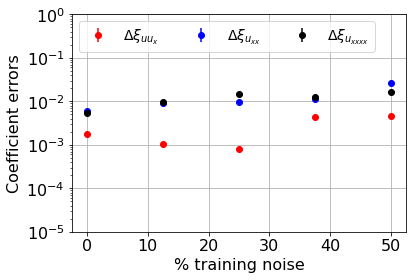

In [15]:
# Find mean and std over the validation runs
delta_c1_mean = np.nanmean(delta_c1, axis=0)
delta_c2_mean = np.nanmean(delta_c2, axis=0)
delta_c3_mean = np.nanmean(delta_c3, axis=0)

delta_c1_std = np.nanstd(delta_c1, axis=0)
delta_c2_std = np.nanstd(delta_c2, axis=0)
delta_c3_std = np.nanstd(delta_c3, axis=0)

# Plot average and standard deviations of the coefficient errors
plt.figure()
plt.errorbar(
    noise_levels / rmse * 100,
    y=delta_c1_mean,
    yerr=delta_c1_std,
    color="r",
    fmt="o",
    label=r"$\Delta\xi_{uu_x}$",
)
plt.errorbar(
    noise_levels / rmse * 100,
    y=delta_c2_mean,
    yerr=delta_c2_std,
    color="b",
    fmt="o",
    label=r"$\Delta\xi_{u_{xx}}$",
)
plt.errorbar(
    noise_levels / rmse * 100,
    y=delta_c3_mean,
    yerr=delta_c3_std,
    color="k",
    fmt="o",
    label=r"$\Delta\xi_{u_{xxxx}}$",
)
plt.yscale("log")
plt.legend(
    fontsize=14, loc="upper left", ncol=3
)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
ax = plt.gca()
ax.set_ylim(1e-5, 1)
plt.xlabel('% training noise', fontsize=16)
plt.ylabel('Coefficient errors', fontsize=16)
plt.savefig("SR3_weakformPDE_KS.png")

# Test weak form PDE functionality on Reaction-Diffusion system
We now demonstrate another more advanced example - using the weak formulation of SINDy to robustly identify a 2D PDE.
This 2D system is significantly more complicated. The reaction-diffusion system exhibits spiral waves on a periodic domain,and the PDEs are:
$$u_t = 0.1\nabla^2 u + (1-A^2)u +\beta A^2v$$
$$v_t = 0.1\nabla^2 v - \beta A^2 u + (1-A^2)v$$
$$A^2 = u^2 + v^2.$$
The main change will be a significantly larger library... cubic terms in (u, v) and all their first and second order derivatives. We will also need to generate the data because saving a high-resolution form of the data makes a fairly large file. See the Example 10 Jupyter notebook for the non-weak-form system identification of the reaction-diffusion system.

Note that the Rudy PDE-FIND paper and Messenger Weak SINDy paper use 256 spatial points in each spatial direction, but Reinbold weak SINDy PRE paper uses 512 points in each direction. We will try and get away with only 64 points in each direction for speed (with normal PDE-FIND this would be a liability because the high order derivatives are very noisy), and still show robustness to ~ 10% noise levels

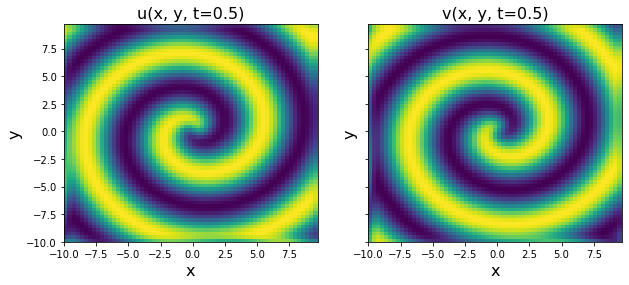

In [16]:
from numpy.fft import fft2, ifft2

# Define the reaction-diffusion PDE in the Fourier (kx, ky) space
def reaction_diffusion(t, uvt, K22, d1, d2, beta, n, N):
    ut = np.reshape(uvt[:N], (n, n))
    vt = np.reshape(uvt[N : 2 * N], (n, n))
    u = np.real(ifft2(ut))
    v = np.real(ifft2(vt))
    u3 = u ** 3
    v3 = v ** 3
    u2v = (u ** 2) * v
    uv2 = u * (v ** 2)
    utrhs = np.reshape((fft2(u - u3 - uv2 + beta * u2v + beta * v3)), (N, 1))
    vtrhs = np.reshape((fft2(v - u2v - v3 - beta * u3 - beta * uv2)), (N, 1))
    uvt_reshaped = np.reshape(uvt, (len(uvt), 1))
    uvt_updated = np.squeeze(
        np.vstack(
            (-d1 * K22 * uvt_reshaped[:N] + utrhs, -d2 * K22 * uvt_reshaped[N:] + vtrhs)
        )
    )
    return uvt_updated


# Generate the data
t = np.linspace(0, 10, int(10 / 0.1))
d1 = 0.1
d2 = 0.1
beta = 1.0
L = 20  # Domain size in X and Y directions
# use n = 32 for speed but then the high-order derivatives are terrible
n = 64  # Number of spatial points in each direction
N = n * n
x_uniform = np.linspace(-L / 2, L / 2, n + 1)
x = x_uniform[:n]
y = x_uniform[:n]
n2 = int(n / 2)
# Define Fourier wavevectors (kx, ky)
kx = (2 * np.pi / L) * np.hstack((np.linspace(0, n2 - 1, n2), np.linspace(-n2, -1, n2)))
ky = kx
# Get 2D meshes in (x, y) and (kx, ky)
X, Y = np.meshgrid(x, y)
KX, KY = np.meshgrid(kx, ky)
K2 = KX ** 2 + KY ** 2
K22 = np.reshape(K2, (N, 1))

m = 1  # number of spirals

# define our solution vectors
u = np.zeros((len(x), len(y), len(t)))
v = np.zeros((len(x), len(y), len(t)))

# Initial conditions
u[:, :, 0] = np.tanh(np.sqrt(X ** 2 + Y ** 2)) * np.cos(
    m * np.angle(X + 1j * Y) - (np.sqrt(X ** 2 + Y ** 2))
)
v[:, :, 0] = np.tanh(np.sqrt(X ** 2 + Y ** 2)) * np.sin(
    m * np.angle(X + 1j * Y) - (np.sqrt(X ** 2 + Y ** 2))
)

# uvt is the solution vector in Fourier space, so below
# we are initializing the 2D FFT of the initial condition, uvt0
uvt0 = np.squeeze(
    np.hstack(
        (np.reshape(fft2(u[:, :, 0]), (1, N)), np.reshape(fft2(v[:, :, 0]), (1, N)))
    )
)

# Solve the PDE in the Fourier space, where it reduces to system of ODEs
uvsol = solve_ivp(
    reaction_diffusion, (t[0], t[-1]), y0=uvt0, t_eval=t, 
    args=(K22, d1, d2, beta, n, N)
)
uvsol = uvsol.y

# Reshape things and ifft back into (x, y, t) space from (kx, ky, t) space
for j in range(len(t)):
    ut = np.reshape(uvsol[:N, j], (n, n))
    vt = np.reshape(uvsol[N:, j], (n, n))
    u[:, :, j] = np.real(ifft2(ut))
    v[:, :, j] = np.real(ifft2(vt))

# Plot to check if spiral is nicely reproduced
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.pcolor(X, Y, u[:, :, 10])
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.title('u(x, y, t=0.5)', fontsize=16)
plt.subplot(1, 2, 2)
plt.pcolor(X, Y, v[:, :, 10])
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
ax = plt.gca()
ax.set_yticklabels([])
plt.title('v(x, y, t=0.5)', fontsize=16)

dt = t[1] - t[0]
dx = x[1] - x[0]
dy = y[1] - y[0]

u_sol = u
v_sol = v

In [17]:
time = t
u = np.zeros((n, n, len(time), 2))
u[:, :, :, 0] = u_sol
u[:, :, :, 1] = v_sol
u_flattened = np.reshape(u, (N * len(time), 2))

# Odd polynomial terms in (u, v), up to second order derivatives in (u, v)
library_functions = [
    lambda x: x,
    lambda x: x * x * x,
    lambda x, y: x * y * y,
    lambda x, y: x * x * y,
]
library_function_names = [
    lambda x: x,
    lambda x: x + x + x,
    lambda x, y: x + y + y,
    lambda x, y: x + x + y,
]

# Need to define the 2D spatial grid before calling the library
X, Y = np.meshgrid(x, y)
spatial_grid = np.asarray([X, Y]).T
pde_lib = ps.PDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    derivative_order=2,
    spatial_grid=spatial_grid,
    temporal_grid=time,
    include_bias=False,
    K=100,
    is_uniform=True,
    weak_form=True,
    num_pts_per_domain=30,
)
u_dot_integral = convert_u_dot_2D(u, time, pde_lib)


In [18]:
# Fit the 2D reaction-diffusion equation, weak form style!
optimizer = ps.STLSQ(threshold=0.02, alpha=1e-5, normalize_columns=True)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u_flattened, x_dot=u_dot_integral, quiet=True)
model.print()

(x0)' = 1.004 x0 + -0.002 x1 + -1.004 x0x0x0 + 1.003 x1x1x1 + -1.004 x0x1x1 + 1.003 x0x0x1 + 0.100 x0_11 + 0.100 x0_22 + 0.004 x0x0_1 + -0.002 x0x1_1 + -0.004 x1x0_1 + 0.002 x1x1_1 + -0.004 x0x0x0x0_1 + 0.002 x1x1x1x0_1 + -0.002 x0x1x1x0_1 + -0.004 x0x0x1x0_1 + -0.002 x0x1_11 + 0.002 x1x1_11 + 0.002 x0x0x0x1_11 + -0.003 x0x0_22 + 0.002 x0x1_22 + 0.004 x1x0_22 + -0.002 x1x1_22 + 0.004 x0x0x0x0_22 + -0.002 x0x0x0x1_22
(x1)' = 1.001 x1 + -1.000 x0x0x0 + -1.000 x1x1x1 + -1.000 x0x1x1 + -1.000 x0x0x1 + 0.100 x1_11 + 0.100 x1_22


Okay, so we have captured the essential terms in the clean data case... can we repeat with some added noise?

In [19]:
# Initialize noisy data
rmse = mean_squared_error(u_flattened, np.zeros(u_flattened.shape), squared=False)
u_noisy = u + np.random.normal(0, rmse / 50.0, u.shape)  # Add 2% noise
u_flattened_noisy = np.reshape(u_noisy, (N * len(time), 2))
u_dot_integral_noisy = convert_u_dot_2D(u_noisy, time, pde_lib)

# Fit the 2D reaction-diffusion equation with noise, weak form style!
optimizer = ps.STLSQ(threshold=0.02, alpha=1e-5, normalize_columns=True)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u_flattened_noisy, x_dot=u_dot_integral_noisy, quiet=True)
model.print()

(x0)' = 0.643 x0 + 0.732 x1 + -0.641 x0x0x0 + 0.192 x1x1x1 + -0.640 x0x1x1 + 0.203 x0x0x1 + 0.065 x0_11 + 0.065 x0_22 + -1.473 x0x0_1 + 0.282 x0x1_1 + 2.080 x1x0_1 + -0.322 x1x1_1 + 1.442 x0x0x0x0_1 + -0.236 x1x1x1x0_1 + 0.446 x1x1x1x1_1 + 0.255 x0x1x1x0_1 + -0.691 x0x1x1x1_1 + 0.576 x0x0x1x0_1 + -0.193 x0x1_2 + -0.351 x1x0_2 + 0.211 x1x1_2 + 0.145 x0x0x0x0_2 + 0.323 x0x0x0x1_2 + 0.080 x1x1x1x0_2 + -0.082 x0x1x1x0_2 + 0.142 x0x1x1x1_2 + -0.362 x0x0x1x1_2 + 0.421 x0x1_11 + -0.488 x1x1_11 + -0.478 x0x0x0x1_11 + -1.112 x1x1x1x0_12 + 1.293 x0x1x1x0_12 + 1.182 x0x0x1x0_12 + 0.528 x0x0_22 + 0.040 x0x1_22 + -0.587 x1x0_22 + -0.041 x1x1_22 + -0.684 x0x0x0x0_22 + 0.012 x0x0x0x1_22 + -0.606 x1x1x1x0_22 + 0.085 x1x1x1x1_22 + 0.658 x0x1x1x0_22 + -0.095 x0x1x1x1_22 + 0.660 x0x0x1x0_22
(x1)' = -0.367 x0 + 0.658 x1 + -0.595 x0x0x0 + -0.639 x1x1x1 + -0.591 x0x1x1 + -0.629 x0x0x1 + 0.089 x1_11 + 0.084 x1_22 + -0.111 x0x1_1 + 0.121 x1x1_1 + -0.457 x1x1x1x0_1 + -0.396 x1x1x1x1_1 + 0.519 x0x1x1x0_1 + 0.45

We don't get the correct PDE... why is this?

It is because the resolution of the weak formulation is not high enough. One needs to increase K (the number of subdomains = size of the regression) and num_pts_per_domain (improve the integration, especially important when data is noisy, and we are using simple trapezoid rules). Unfortunately, this is computationally intensive so we leave this improvement out of this example notebook.

# Test weak form PDE functionality on 3D Reaction-Diffusion system
Can even use weak-form for 3D PDEs although this is getting very computationally intensive! 

We illustrate the functionality below but the resolution is comically lower here -- too low here to get a good model -- think of this as an illustration of how you could use this, but higher memory is needed for success!

We will use a 3D reaction-diffusion equation called the Gray-Scott Equation. We are folllowing the example in Section 3.3.3 of Maddu, S., Cheeseman, B. L., Sbalzarini, I. F., & Müller, C. L. (2019). Stability selection enables robust learning of partial differential equations from limited noisy data. arXiv preprint arXiv:1907.07810. ([Link](https://arxiv.org/pdf/1907.07810.pdf)).
$$u_t = D_u\nabla^2 u - uv^2 + 0.014(1-u)$$
$$v_t = D_v\nabla^2 v + uv^2 - 0.067 v$$
We will need to generate some very low-resolution data, because the memory requirements are very significant for a fully 3D problem. We showed in the PDE-FIND Jupyter notebook (Example 10) that the resolution is too low to get all the terms correct. 

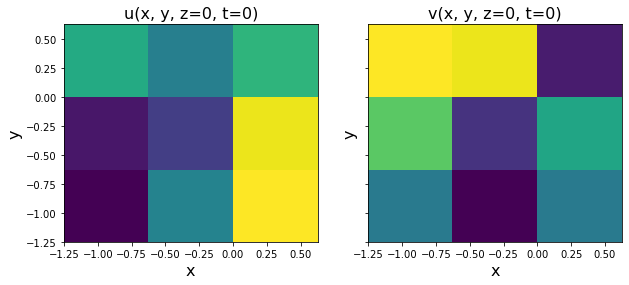

In [20]:
from numpy.fft import fftn, ifftn

# Define the reaction-diffusion PDE in the Fourier (kx, ky, kz) space
def reaction_diffusion(t, uvt, K22, d1, d2, n, N):
    ut = np.reshape(uvt[:N], (n, n, n))
    vt = np.reshape(uvt[N : 2 * N], (n, n, n))
    u = np.real(ifftn(ut, axes=[0, 1, 2]))
    v = np.real(ifftn(vt, axes=[0, 1, 2]))
    uv2 = u * (v ** 2)
    utrhs = np.reshape((fftn(0.014 * (1 - u) - uv2, axes=[0, 1, 2])), (N, 1))
    vtrhs = np.reshape((fftn(uv2 - 0.067 * v, axes=[0, 1, 2])), (N, 1))
    uvt_reshaped = np.reshape(uvt, (len(uvt), 1))
    uvt_updated = np.squeeze(
        np.vstack(
            (-d1 * K22 * uvt_reshaped[:N] + utrhs, -d2 * K22 * uvt_reshaped[N:] + vtrhs)
        )
    )
    return uvt_updated


# Generate the data
dt = 0.5
t = np.linspace(0, 10, int(5 / dt))
d1 = 2e-2
d2 = 1e-2
L = 2.5  # Domain size in X, Y, Z directions
# use n = 32 for speed but then the high-order derivatives are terrible
n = 4  # Number of spatial points in each direction
N = n * n * n
x_uniform = np.linspace(-L / 2, L / 2, n + 1)
x = x_uniform[:n]
y = x_uniform[:n]
z = x_uniform[:n]
n2 = int(n / 2)
# Define Fourier wavevectors (kx, ky, kz)
kx = (2 * np.pi / L) * np.hstack((np.linspace(0, n2 - 1, n2), np.linspace(-n2, -1, n2)))
ky = kx
kz = kx
# Get 3D meshes in (x, y, z) and (kx, ky, kz)
X, Y, Z = np.meshgrid(x, y, z, indexing="ij")
KX, KY, KZ = np.meshgrid(kx, ky, kz, indexing="ij")
K2 = KX ** 2 + KY ** 2 + KZ ** 2
K22 = np.reshape(K2, (N, 1))

m = 3  # number of spirals

# define our solution vectors
u = np.zeros((len(x), len(y), len(z), len(t)))
v = np.zeros((len(x), len(y), len(z), len(t)))

# Initial conditions
u[:, :, :, 0] = np.tanh(np.sqrt(X ** 2 + Y ** 2 + Z ** 2)) * np.cos(
    m * np.angle(X + 1j * Y) - (np.sqrt(X ** 2 + Y ** 2 + Z ** 2))
)
v[:, :, :, 0] = np.tanh(np.sqrt(X ** 2 + Y ** 2 + Z ** 2)) * np.sin(
    m * np.angle(X + 1j * Y) - (np.sqrt(X ** 2 + Y ** 2 + Z ** 2))
)

# uvt is the solution vector in Fourier space, so below
# we are initializing the 2D FFT of the initial condition, uvt0
uvt0 = np.squeeze(
    np.hstack(
        (
            np.reshape(fftn(u[:, :, :, 0], axes=[0, 1, 2]), (1, N)),
            np.reshape(fftn(v[:, :, :, 0], axes=[0, 1, 2]), (1, N)),
        )
    )
)

# Solve the PDE in the Fourier space, where it reduces to system of ODEs
uvsol = solve_ivp(
    reaction_diffusion, (t[0], t[-1]), y0=uvt0, t_eval=t, 
    args=(K22, d1, d2, n, N)
)
uvsol = uvsol.y

# Reshape things and ifft back into (x, y, z, t) space from (kx, ky, kz, t) space
for j in range(len(t)):
    ut = np.reshape(uvsol[:N, j], (n, n, n))
    vt = np.reshape(uvsol[N:, j], (n, n, n))
    u[:, :, :, j] = np.real(ifftn(ut, axes=[0, 1, 2]))
    v[:, :, :, j] = np.real(ifftn(vt, axes=[0, 1, 2]))

# Plot to check if spiral is nicely reproduced
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.pcolor(X[:, :, 0], Y[:, :, 0], u[:, :, 0, 0])
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.title('u(x, y, z=0, t=0)', fontsize=16)
plt.subplot(1, 2, 2)
plt.pcolor(X[:, :, 0], Y[:, :, 0], v[:, :, 0, 0])
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
ax = plt.gca()
ax.set_yticklabels([])
plt.title('v(x, y, z=0, t=0)', fontsize=16)

dt = t[1] - t[0]
dx = x[1] - x[0]
dy = y[1] - y[0]
dz = z[1] - z[0]

u_sol = u
v_sol = v

In [21]:
time = t
u = np.zeros((n, n, n, len(time), 2))
u[:, :, :, :, 0] = u_sol
u[:, :, :, :, 1] = v_sol
u_dot = np.zeros((n, n, n, len(t), 2))
for i in range(n):
    for j in range(n):
        for k in range(n):
            u_dot[i, j, k, :, :] = ps.FiniteDifference()._differentiate(
                u[i, j, k, :, :], dt
            )
u_flattened = np.reshape(u, (N * len(time), 2))
u_dot_flattened = np.reshape(u_dot, (N * len(time), 2))

# Odd polynomial terms in (u, v), up to second order derivatives in (u, v)
library_functions = [
    lambda x: x,
    lambda x: x * x * x,
    lambda x, y: x * y * y,
    lambda x, y: x * x * y,
]
library_function_names = [
    lambda x: x,
    lambda x: x + x + x,
    lambda x, y: x + y + y,
    lambda x, y: x + x + y,
]

# Need to define the 2D spatial grid before calling the library
X, Y, Z = np.meshgrid(x, y, z, indexing="ij")
spatial_grid = np.asarray([X, Y, Z])
spatial_grid = np.transpose(spatial_grid, axes=[1, 2, 3, 0])
pde_lib = ps.PDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    derivative_order=2,
    spatial_grid=spatial_grid,
    temporal_grid=time,
    include_bias=False,
    K=20,
    is_uniform=True,
    weak_form=True,
    num_pts_per_domain=10,
    include_interaction=False,
)
u_dot_integral = convert_u_dot_3D(u, time, pde_lib)

In [22]:
# Fit the 3D reaction-diffusion equation
optimizer = ps.SR3(threshold=1e-8, normalize_columns=True)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u_flattened, x_dot=u_dot_integral, quiet=True)
model.print()
coefs = optimizer.coef_

(x0)' = -1003.824 x0 + -408.651 x1 + -0.007 x0x0x0 + 0.002 x1x1x1 + 0.006 x0x1x1 + -0.001 x0x0x1 + 0.187 x0_1 + -0.003 x1_1 + -0.005 x0_2 + -0.004 x1_2 + -0.005 x0_3 + -0.004 x1_3 + -0.001 x0_12 + -0.003 x1_12 + -0.001 x0_13 + -0.003 x1_13 + -0.547 x0_22 + -0.223 x1_22 + 0.722 x0_23 + 0.294 x1_23 + -0.547 x0_33 + -0.222 x1_33
(x1)' = 2911.270 x0 + 580.911 x1 + -0.124 x0x0x0 + -0.009 x1x1x1 + -0.108 x0x1x1 + 0.200 x0x0x1 + -0.003 x0_1 + 0.185 x1_1 + -0.031 x0_2 + -0.005 x1_2 + -0.031 x0_3 + -0.005 x1_3 + -0.001 x1_11 + -0.011 x0_12 + -0.003 x1_12 + -0.011 x0_13 + -0.003 x1_13 + 1.587 x0_22 + 0.317 x1_22 + -2.094 x0_23 + -0.419 x1_23 + 1.587 x0_33 + 0.315 x1_33


Note the fit here is really bad... this is because K and num_pts_per_domain need to be 
larger for an accurate fit, but we are constrained by the heavy memory usage. Reducing the 
memory use in the code is a good place for future improvements.